# Generate scaled graph 

We scale the graph to make the size of each district proportional to its population. To do so, we use make Stochastic Block Model network, and we fit the parameters to make an SIR epidemic spreading over the network statistically look like the projected number of Ebola cases from the study [Ebola Virus Disease in West Africa — The First 9 Months of the Epidemic and Forward Projections](https://www.nejm.org/doi/full/10.1056/NEJMoa1411100) (See projections in Suppl. material 2).

In particular, we match the doubling time for the initial exponential growth of the epidemic.

The parameters are:
* `n_nodes`: the size of the network
* `p_in`: the intra-district probability 
* `p_ou`: the inter-district probability

---

Load libs.

In [2]:
%load_ext autoreload
%autoreload 2

Add the project base directory to the path

In [3]:
import sys
if '..' not in sys.path:
    sys.path.append('..')

In [4]:
from matplotlib import pyplot as plt
%matplotlib inline

import pandas as pd
import networkx as nx

from graph_generation import make_ebola_network
from dynamics import SIRDynamicalSystem

---

## Define SIR epidemic parameters

We use the values estimated from the literature

In [228]:
beta = 1.0 / 15.3  # Serial interval time (from literature)
delta = 1.0 / 11.4  # Course of infection (from literature)

## Build propagation network

Set the stochastic block model network parameters

In [229]:
n_nodes = 100000
p_in = 0.0008
p_out = p_in / 5

Generate the graph

In [230]:
graph = make_ebola_network(n_nodes=n_nodes, p_in=p_in, p_out=p_out)
A = nx.adjacency_matrix(graph).toarray()

n_nodes = graph.number_of_nodes()

print(graph.number_of_nodes(), graph.number_of_edges())

91027 182095


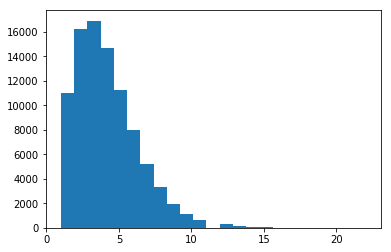

In [231]:
degree_sequence = [d for n, d in graph.degree()]
max_deg = max(degree_sequence)
plt.hist(degree_sequence, bins=max_deg+1);

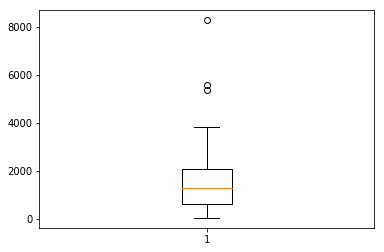

In [232]:
cluster_sizes = np.bincount([d['block'] for u,d in graph.nodes(data=True)])
plt.boxplot(cluster_sizes);

---

## Run simulation on the network to validate the parameters

Extract seeds

In [234]:
def sample_seeds(n_seeds=None, max_date=None):
    """
    Extract seeds from the Ebola cases datasets, by choosing either:
    * the first `n_seeds`. 
    * the first seed until the date `max_date`.
    We then simulate the recovery rate of the seed, and start
    the epidemics at the infection time of the last seed.
    Note that some seeds may have already recovered at this time. In 
    this case, they are just ignored from the simulation.
    """
    assert (n_seeds is None) or (max_date is None)
    # Load real data
    df = pd.read_csv('../data/ebola/rstb20160308_si_001_cleaned.csv')
    if n_seeds:
        df = df.sort_values('infection_timestamp').iloc[:n_seeds]
    elif max_date:
        df = df[df.infection_date < max_date].sort_values('infection_timestamp')
    # Extract the seed disctricts
    seed_names = list(df['district'])
    # Extract district name for each node in the graph
    node_names = np.array([u for u, d in graph.nodes(data=True)])
    node_districts = np.array([d['district'] for u, d in graph.nodes(data=True)])
    # Get last infection time of seeds (this is time zero for the simulation)
    last_inf_time = df.infection_timestamp.max()
    # Init list of seed events
    init_event_list = list()
    for _, row in df.iterrows():
        inf_time = row['infection_timestamp']
        # Sample recovery time
        rec_time = inf_time + np.random.exponential(1./delta) - last_inf_time
        # Ignore seed if recovered before time zero
#         print(f'Seed from district {row["district"]} infected on {row["infection_date"]}')
        if rec_time > 0:
            # Randomly sample one node for each seed in the corresponding district
            idx = np.random.choice(np.where(node_districts == row['district'])[0])
            node = node_names[idx]
            # Add infection event
            init_event_list.append([(node, 'inf', False), 0.0])  # Gets infection at the start of the epidemic
            # Add recovery event
            init_event_list.append([(node, 'rec', False), rec_time])  # Artificial recovery
            print(f'Add seed {node} from district {row["district"]} - inf: {0.0}, rec: {rec_time} ')
    return init_event_list

---

### 1. Run simulations on the early epidemic to validate the network

We start with seeds until Feb 26, 2014 and run the epidemic for a couple months. At this time, we expect that their was no control measures affecting the epidemic parameters.

We verify that the empirical value of $R_0$ (i.e. the average number of secondary cases infected by primary infections) roughly matches the observed values of $1.5 < R_0 < 2$. 

In [239]:
from epidemics_helper import SimulationSIR

n_trials = 5

res = list()
for i in range(n_trials):
    print(f'=== {i+1:d}')
    init_event_list = sample_seeds(max_date='2014-01-26')
    sir = SimulationSIR(graph, beta=1.0/15.3 - 0.0/15.3, gamma=1.0/11.4 - 0.0/11.4, verbose=True)
    sir.launch_epidemic(init_event_list=init_event_list, max_time=10 * 7)
    res.append(sir)

=== 1
Add seed 21971 from district GUECKEDOU - inf: 0.0, rec: 0.46557146710176056 
Add seed 20854 from district GUECKEDOU - inf: 0.0, rec: 0.8724643526578504 
Epidemic stopped after 0.87 days | 0.87 days elapsed | 100.0% susceptible, 0.0% infected, 0.0% recovered
=== 2
Add seed 87717 from district PUJEHUN - inf: 0.0, rec: 29.44974404031926 
Add seed 19166 from district GUECKEDOU - inf: 0.0, rec: 3.222289591703948 
Add seed 19684 from district GUECKEDOU - inf: 0.0, rec: 15.678880168492697 
Add seed 21734 from district GUECKEDOU - inf: 0.0, rec: 3.742988625528639 
Epidemic stopped after 70.00 days | 70.00 days elapsed | 64.0% susceptible, 14.2% infected, 21.8% recovered
=== 3
Add seed 86733 from district PUJEHUN - inf: 0.0, rec: 16.625232831314456 
Add seed 21389 from district GUECKEDOU - inf: 0.0, rec: 7.587276356270195 
Add seed 20965 from district GUECKEDOU - inf: 0.0, rec: 4.003435730471459 
Add seed 21354 from district GUECKEDOU - inf: 0.0, rec: 11.699193991094411 
Epidemic stopped 

In [223]:
def estimate_Rt(sir, week_num):
    early_infected_node_args = (sir.inf_time >= 0 * week_num ) & (sir.inf_time < 7 * (week_num + 1))
    early_infected_nodes_idx = np.where(early_infected_node_args)[0]
    return sir.num_child_inf[early_infected_node_args].sum() / sum(early_infected_node_args)

In [224]:
rt_list = np.array([[estimate_Rt(sir, n) for n in range(10)] for sir in res])

(0, 3.0)

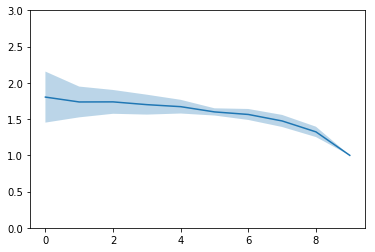

In [226]:
plt.fill_between(
    range(10), 
    rt_list.mean(axis=0) - rt_list.std(axis=0), 
    rt_list.mean(axis=0) + rt_list.std(axis=0),
    alpha=0.3
)
plt.plot(range(10), rt_list.mean(axis=0))
plt.ylim(0, 3.0)

---

### 2. Run simulations on in the latter part of the epidemic to validate the intervention parameters.

Run simulations starting in September 2014, and verify that the rate of infection roughly matches the projections estimated in the literature.

Projected number of cases each week starting on September 8, 2014. (Mean, 5% CI, 95% CI)

In [275]:
expected_projection = np.array([
    [1215, 798, 1905],
    [1555, 942, 2654],
    [2042, 1145, 3792],
    [2738, 1419, 5529],
    [3727, 1808, 8126],
    [5153, 2351, 12082],
    [7202, 3081, 18043],
    [10122, 4083, 27159],
    [14272, 5463, 40942],
    [20213, 7349, 61766],
    [28752, 9896, 93011]
])

n_weeks = len(expected_projection)

Set values for the intervation parameters

In [290]:
gamma = 0.6 / 15.3  # Reduction in infection rate under treatment
rho = -0.3 / 11.4 # Recovery rate from treatment (if negative, then treatment means longer infections, and/or die less quickly)

In [291]:
from epidemics_helper import SimulationSIR

n_trials = 5

res = list()
for i in range(n_trials):
    print(f'=== {i+1:d}')
    init_event_list = sample_seeds(max_date='2014-09-08')
    sir = SimulationSIR(graph, beta=beta - gamma, gamma=delta + rho, verbose=True)
    sir.launch_epidemic(init_event_list=init_event_list, max_time=n_weeks * 7)
    res.append(sir)

=== 1
Add seed 70171 from district BONG - inf: 0.0, rec: 0.19369954645037524 
Add seed 82136 from district MONTSERRADO - inf: 0.0, rec: 5.431455471587412 
Add seed 48997 from district BOMBALI - inf: 0.0, rec: 3.2752875353956483 
Add seed 25173 from district LOFA - inf: 0.0, rec: 3.337623654513834 
Add seed 72259 from district KENEMA - inf: 0.0, rec: 4.791364974004296 
Add seed 78344 from district BOMI - inf: 0.0, rec: 11.501565845018433 
Add seed 78033 from district BOMI - inf: 0.0, rec: 40.22826748663897 
Add seed 74660 from district KENEMA - inf: 0.0, rec: 28.93204855945919 
Add seed 82422 from district MONTSERRADO - inf: 0.0, rec: 5.126354625729107 
Add seed 67442 from district PORT_LOKO - inf: 0.0, rec: 16.274169450289037 
Add seed 70376 from district BONG - inf: 0.0, rec: 0.31431132349348445 
Add seed 80346 from district MONTSERRADO - inf: 0.0, rec: 6.3229613247283964 
Add seed 61907 from district KAILAHUN - inf: 0.0, rec: 10.274942075865795 
Add seed 74041 from district KENEMA - 

Add seed 67915 from district PORT_LOKO - inf: 0.0, rec: 19.291008322091045 
Add seed 98599 from district WESTERN - inf: 0.0, rec: 13.833502099854002 
Add seed 81545 from district MONTSERRADO - inf: 0.0, rec: 6.904548745931265 
Add seed 81949 from district MONTSERRADO - inf: 0.0, rec: 18.253563029742168 
Add seed 81837 from district MONTSERRADO - inf: 0.0, rec: 9.055087231907692 
Add seed 7619 from district MACENTA - inf: 0.0, rec: 5.989768311803232 
Add seed 42116 from district COYAH - inf: 0.0, rec: 8.440352839466527 
Add seed 85660 from district MONTSERRADO - inf: 0.0, rec: 0.6013451263702336 
Add seed 84728 from district MONTSERRADO - inf: 0.0, rec: 0.7718527679078591 
Add seed 85109 from district MONTSERRADO - inf: 0.0, rec: 5.36599777877268 
Add seed 25610 from district LOFA - inf: 0.0, rec: 18.273864042613468 
Add seed 50753 from district BOMBALI - inf: 0.0, rec: 4.694161429704991 
Add seed 78619 from district MARGIBI - inf: 0.0, rec: 17.22922034678942 
Add seed 82468 from distri

Add seed 68192 from district PORT_LOKO - inf: 0.0, rec: 12.172130855594958 
Add seed 82880 from district MONTSERRADO - inf: 0.0, rec: 21.208359882351317 
Add seed 7353 from district MACENTA - inf: 0.0, rec: 4.98300435979445 
Add seed 81961 from district MONTSERRADO - inf: 0.0, rec: 3.4853699882370393 
Add seed 85390 from district MONTSERRADO - inf: 0.0, rec: 25.749378964187258 
Add seed 82398 from district MONTSERRADO - inf: 0.0, rec: 10.894663564255552 
Add seed 4680 from district KEROUANE - inf: 0.0, rec: 1.2645639256497248 
Add seed 25513 from district LOFA - inf: 0.0, rec: 0.0016169224361703982 
Add seed 61485 from district KAILAHUN - inf: 0.0, rec: 21.45610125475406 
Add seed 78497 from district BOMI - inf: 0.0, rec: 7.079326667762928 
Add seed 66807 from district PORT_LOKO - inf: 0.0, rec: 0.8842929738303553 
Add seed 82325 from district MONTSERRADO - inf: 0.0, rec: 6.868355211915571 
Add seed 90219 from district BO - inf: 0.0, rec: 8.726921887270692 
Add seed 7024 from district 

Add seed 81191 from district MONTSERRADO - inf: 0.0, rec: 24.401064630793314 
Add seed 20851 from district GUECKEDOU - inf: 0.0, rec: 5.481551046398579 
Add seed 98400 from district WESTERN - inf: 0.0, rec: 5.677971471261401 
Add seed 79440 from district MARGIBI - inf: 0.0, rec: 2.5243179826186974 
Add seed 8472 from district MACENTA - inf: 0.0, rec: 12.966402133172835 
Add seed 83843 from district MONTSERRADO - inf: 0.0, rec: 5.786318700578363 
Add seed 67120 from district PORT_LOKO - inf: 0.0, rec: 6.6210541073238005 
Add seed 78670 from district MARGIBI - inf: 0.0, rec: 9.805764295603751 
Add seed 85684 from district MONTSERRADO - inf: 0.0, rec: 13.30217895063987 
Add seed 6854 from district MACENTA - inf: 0.0, rec: 3.7747604609240852 
Add seed 72691 from district KENEMA - inf: 0.0, rec: 16.021611172172754 
Add seed 81139 from district MONTSERRADO - inf: 0.0, rec: 1.7656240577495623 
Add seed 96669 from district WESTERN - inf: 0.0, rec: 10.034614246254307 
Add seed 84592 from distri

Add seed 82398 from district MONTSERRADO - inf: 0.0, rec: 43.34514604599042 
Add seed 94994 from district WESTERN - inf: 0.0, rec: 5.019352512087039 
Add seed 78838 from district MARGIBI - inf: 0.0, rec: 1.5927045137864866 
Add seed 93702 from district MOYAMBA - inf: 0.0, rec: 40.794139860749965 
Add seed 68685 from district PORT_LOKO - inf: 0.0, rec: 5.284569484569545 
Add seed 83812 from district MONTSERRADO - inf: 0.0, rec: 9.605913427112057 
Add seed 99851 from district WESTERN - inf: 0.0, rec: 3.179353003698793 
Add seed 79842 from district MARGIBI - inf: 0.0, rec: 5.886523825176312 
Add seed 80695 from district MONTSERRADO - inf: 0.0, rec: 8.850122084446753 
Add seed 16374 from district NIMBA - inf: 0.0, rec: 1.6751644425306722 
Add seed 20346 from district GUECKEDOU - inf: 0.0, rec: 2.386425534849991 
Add seed 82282 from district MONTSERRADO - inf: 0.0, rec: 10.350841501024206 
Add seed 7816 from district MACENTA - inf: 0.0, rec: 1.7554618319013002 
Add seed 82804 from district 

Add seed 63866 from district KONO - inf: 0.0, rec: 2.188718055605648 
Add seed 69395 from district BONG - inf: 0.0, rec: 15.987889975897644 
Add seed 80469 from district MONTSERRADO - inf: 0.0, rec: 2.8008867382550307 
Add seed 79381 from district MARGIBI - inf: 0.0, rec: 32.50726577037284 
Add seed 66533 from district PORT_LOKO - inf: 0.0, rec: 9.550769975961543 
Add seed 83948 from district MONTSERRADO - inf: 0.0, rec: 0.13438328023281088 
Add seed 61272 from district KAILAHUN - inf: 0.0, rec: 6.761004921888855 
Add seed 69003 from district PORT_LOKO - inf: 0.0, rec: 1.071921205800379 
Add seed 64834 from district TONKOLILI - inf: 0.0, rec: 14.523313196858112 
Add seed 82600 from district MONTSERRADO - inf: 0.0, rec: 3.472148474369874 
Add seed 8136 from district MACENTA - inf: 0.0, rec: 4.3346118417759385 
Add seed 85591 from district MONTSERRADO - inf: 0.0, rec: 12.689295106775376 
Add seed 8360 from district MACENTA - inf: 0.0, rec: 17.609015036972266 
Add seed 68148 from district

Add seed 97356 from district WESTERN - inf: 0.0, rec: 11.66784708811582 
Add seed 83534 from district MONTSERRADO - inf: 0.0, rec: 1.730936616703275 
Add seed 96847 from district WESTERN - inf: 0.0, rec: 20.423920205287857 
Add seed 96619 from district WESTERN - inf: 0.0, rec: 3.0021612171010474 
Add seed 8411 from district MACENTA - inf: 0.0, rec: 22.80619835849319 
Add seed 69400 from district BONG - inf: 0.0, rec: 12.052079857710225 
Add seed 95566 from district WESTERN - inf: 0.0, rec: 17.82597815560655 
Add seed 96709 from district WESTERN - inf: 0.0, rec: 4.0120454046301575 
Add seed 79185 from district MARGIBI - inf: 0.0, rec: 1.152018795149445 
Add seed 82707 from district MONTSERRADO - inf: 0.0, rec: 5.414163478846831 
Add seed 67120 from district PORT_LOKO - inf: 0.0, rec: 1.8851284068520044 
Add seed 75177 from district GRAND_BASSA - inf: 0.0, rec: 15.442054139696097 
Add seed 85722 from district MONTSERRADO - inf: 0.0, rec: 13.025127452667732 
Add seed 95831 from district W

Add seed 98132 from district WESTERN - inf: 0.0, rec: 3.3868985975526016 
Add seed 65709 from district TONKOLILI - inf: 0.0, rec: 4.939359869622933 
Add seed 81716 from district MONTSERRADO - inf: 0.0, rec: 1.4025773872845662 
Add seed 80319 from district MONTSERRADO - inf: 0.0, rec: 1.7064198127906707 
Add seed 85795 from district MONTSERRADO - inf: 0.0, rec: 6.343988263367294 
Add seed 85298 from district MONTSERRADO - inf: 0.0, rec: 24.322462223776768 
Add seed 80575 from district MONTSERRADO - inf: 0.0, rec: 3.7665147689610308 
Add seed 10434 from district NZEREKORE - inf: 0.0, rec: 24.724677780100762 
Add seed 52092 from district KAMBIA - inf: 0.0, rec: 4.446636378859068 
Add seed 64823 from district TONKOLILI - inf: 0.0, rec: 10.939261427489555 
Add seed 82140 from district MONTSERRADO - inf: 0.0, rec: 5.994296768648383 
Add seed 84818 from district MONTSERRADO - inf: 0.0, rec: 3.7493123567016937 
Add seed 97556 from district WESTERN - inf: 0.0, rec: 7.051361767469928 
Add seed 5

Add seed 67888 from district PORT_LOKO - inf: 0.0, rec: 3.5339928486801 
Add seed 95881 from district WESTERN - inf: 0.0, rec: 45.664490567943346 
Add seed 85694 from district MONTSERRADO - inf: 0.0, rec: 18.740633516927062 
Add seed 97121 from district WESTERN - inf: 0.0, rec: 0.8320829858510876 
Add seed 84967 from district MONTSERRADO - inf: 0.0, rec: 0.10393994218665625 
Add seed 50673 from district BOMBALI - inf: 0.0, rec: 2.8935502112391305 
Add seed 17479 from district NIMBA - inf: 0.0, rec: 1.957847962611197 
Add seed 60868 from district KAILAHUN - inf: 0.0, rec: 1.5421835327029498 
Add seed 92175 from district GRAND_KRU - inf: 0.0, rec: 23.567505941019192 
Add seed 80767 from district MONTSERRADO - inf: 0.0, rec: 14.323152655175647 
Add seed 85330 from district MONTSERRADO - inf: 0.0, rec: 12.771033402664443 
Add seed 81541 from district MONTSERRADO - inf: 0.0, rec: 0.3345221507744043 
Add seed 98625 from district WESTERN - inf: 0.0, rec: 12.970288697 
Add seed 90497 from dist

Add seed 33390 from district CONAKRY - inf: 0.0, rec: 4.9515279256265785 
Add seed 88012 from district BO - inf: 0.0, rec: 19.31278690354054 
Add seed 78791 from district MARGIBI - inf: 0.0, rec: 14.530164461790775 
Add seed 84300 from district MONTSERRADO - inf: 0.0, rec: 3.9142225009261438 
Add seed 90307 from district BO - inf: 0.0, rec: 20.06033984636707 
Add seed 98359 from district WESTERN - inf: 0.0, rec: 2.201272789224845 
Add seed 84945 from district MONTSERRADO - inf: 0.0, rec: 1.91018707594435 
Add seed 79700 from district MARGIBI - inf: 0.0, rec: 6.0358326504150455 
Add seed 95336 from district WESTERN - inf: 0.0, rec: 7.513757932391627 
Add seed 6602 from district MACENTA - inf: 0.0, rec: 0.9368744340919761 
Add seed 80000 from district MARGIBI - inf: 0.0, rec: 1.7637591279120102 
Add seed 80144 from district MARGIBI - inf: 0.0, rec: 4.650774101726995 
Add seed 84888 from district MONTSERRADO - inf: 0.0, rec: 2.1943248748162887 
Add seed 87505 from district PUJEHUN - inf: 

Add seed 81964 from district MONTSERRADO - inf: 0.0, rec: 3.637445203643267 
Add seed 60878 from district KAILAHUN - inf: 0.0, rec: 4.608704185211934 
Add seed 16626 from district NIMBA - inf: 0.0, rec: 2.932590651136991 
Add seed 98768 from district WESTERN - inf: 0.0, rec: 3.9404800355491716 
Add seed 84833 from district MONTSERRADO - inf: 0.0, rec: 3.012043558148264 
Add seed 73367 from district KENEMA - inf: 0.0, rec: 14.020486550508565 
Add seed 60679 from district KAILAHUN - inf: 0.0, rec: 2.31475278142193 
Add seed 79932 from district MARGIBI - inf: 0.0, rec: 1.2909744874714875 
Add seed 79980 from district MARGIBI - inf: 0.0, rec: 21.649929011603604 
Add seed 83823 from district MONTSERRADO - inf: 0.0, rec: 21.698669183591335 
Add seed 25172 from district LOFA - inf: 0.0, rec: 7.984717124847975 
Add seed 3911 from district KEROUANE - inf: 0.0, rec: 2.207682779677384 
Add seed 7143 from district MACENTA - inf: 0.0, rec: 4.406199241937145 
Add seed 69518 from district BONG - inf:

Add seed 89418 from district BO - inf: 0.0, rec: 4.63031016502066 
Add seed 24403 from district LOFA - inf: 0.0, rec: 39.281235104813504 
Add seed 79345 from district MARGIBI - inf: 0.0, rec: 1.8418966729786348 
Add seed 8159 from district MACENTA - inf: 0.0, rec: 51.40905517094694 
Add seed 84862 from district MONTSERRADO - inf: 0.0, rec: 4.242586417986388 
Add seed 74822 from district KENEMA - inf: 0.0, rec: 13.141658212054438 
Add seed 80885 from district MONTSERRADO - inf: 0.0, rec: 2.9236799512893867 
Add seed 7554 from district MACENTA - inf: 0.0, rec: 3.2716455695806985 
Add seed 83913 from district MONTSERRADO - inf: 0.0, rec: 16.80545074416034 
Add seed 85497 from district MONTSERRADO - inf: 0.0, rec: 12.655321102831465 
Add seed 68183 from district PORT_LOKO - inf: 0.0, rec: 2.139567728583188 
Add seed 99578 from district WESTERN - inf: 0.0, rec: 37.236875132100295 
Add seed 99145 from district WESTERN - inf: 0.0, rec: 0.3488999021129189 
Add seed 84114 from district MONTSERR

Add seed 85716 from district MONTSERRADO - inf: 0.0, rec: 4.389873634152707 
Add seed 83224 from district MONTSERRADO - inf: 0.0, rec: 27.079650662871643 
Add seed 80995 from district MONTSERRADO - inf: 0.0, rec: 6.7418637765724725 
Add seed 80595 from district MONTSERRADO - inf: 0.0, rec: 6.334029893032664 
Add seed 85723 from district MONTSERRADO - inf: 0.0, rec: 0.3183509965574842 
Add seed 82731 from district MONTSERRADO - inf: 0.0, rec: 32.39514386773715 
Add seed 78951 from district MARGIBI - inf: 0.0, rec: 17.965965407760677 
Add seed 29727 from district DUBREKA - inf: 0.0, rec: 1.5375045564315428 
Add seed 79395 from district MARGIBI - inf: 0.0, rec: 4.052571632339777 
Add seed 81466 from district MONTSERRADO - inf: 0.0, rec: 7.089820541438485 
Add seed 98312 from district WESTERN - inf: 0.0, rec: 4.531470549945595 
Add seed 80283 from district MONTSERRADO - inf: 0.0, rec: 21.513547764249267 
Add seed 6291 from district MACENTA - inf: 0.0, rec: 19.345473833645656 
Add seed 1927

Add seed 67531 from district PORT_LOKO - inf: 0.0, rec: 3.1106427963251804 
Add seed 17541 from district NIMBA - inf: 0.0, rec: 1.400455613248198 
Add seed 50931 from district BOMBALI - inf: 0.0, rec: 11.285525587254881 
Add seed 68199 from district PORT_LOKO - inf: 0.0, rec: 13.576863082925684 
Add seed 79626 from district MARGIBI - inf: 0.0, rec: 9.692267621128394 
Add seed 97945 from district WESTERN - inf: 0.0, rec: 5.900397319125261 
Add seed 80851 from district MONTSERRADO - inf: 0.0, rec: 6.335527600640205 
Add seed 79292 from district MARGIBI - inf: 0.0, rec: 34.83370241073516 
Add seed 80681 from district MONTSERRADO - inf: 0.0, rec: 7.045276761736943 
Add seed 99840 from district WESTERN - inf: 0.0, rec: 18.693096305945915 
Add seed 69056 from district PORT_LOKO - inf: 0.0, rec: 5.121984572010945 
Add seed 83608 from district MONTSERRADO - inf: 0.0, rec: 5.995446961215293 
Add seed 84551 from district MONTSERRADO - inf: 0.0, rec: 6.431553908168553 
Add seed 83550 from distric

Add seed 84322 from district MONTSERRADO - inf: 0.0, rec: 1.2258594801857043 
Add seed 81693 from district MONTSERRADO - inf: 0.0, rec: 3.967321576629729 
Add seed 79411 from district MARGIBI - inf: 0.0, rec: 21.08978444191456 
Add seed 79753 from district MARGIBI - inf: 0.0, rec: 24.033303519098013 
Add seed 83628 from district MONTSERRADO - inf: 0.0, rec: 31.03075419108967 
Add seed 16802 from district NIMBA - inf: 0.0, rec: 28.685404227391928 
Add seed 83743 from district MONTSERRADO - inf: 0.0, rec: 0.14227515778941324 
Add seed 79330 from district MARGIBI - inf: 0.0, rec: 3.7872830075141337 
Add seed 79942 from district MARGIBI - inf: 0.0, rec: 11.357505896860232 
Add seed 24058 from district LOFA - inf: 0.0, rec: 6.030737538736105 
Add seed 6257 from district MACENTA - inf: 0.0, rec: 0.7547932741750287 
Add seed 61533 from district KAILAHUN - inf: 0.0, rec: 2.7100627930506107 
Add seed 97738 from district WESTERN - inf: 0.0, rec: 25.988718277577846 
Add seed 80293 from district M

Add seed 82068 from district MONTSERRADO - inf: 0.0, rec: 19.808779655031913 
Add seed 68599 from district PORT_LOKO - inf: 0.0, rec: 3.804840401571994 
Add seed 63671 from district KONO - inf: 0.0, rec: 0.303863567198988 
Add seed 64637 from district TONKOLILI - inf: 0.0, rec: 16.32457836806293 
Add seed 96635 from district WESTERN - inf: 0.0, rec: 25.19384456612306 
Add seed 18143 from district NIMBA - inf: 0.0, rec: 5.649305955313196 
Add seed 99125 from district WESTERN - inf: 0.0, rec: 14.269777761929959 
Add seed 96823 from district WESTERN - inf: 0.0, rec: 14.295250063079777 
Add seed 81857 from district MONTSERRADO - inf: 0.0, rec: 61.82922414559971 
Add seed 68816 from district PORT_LOKO - inf: 0.0, rec: 2.2284487475672563 
Add seed 96197 from district WESTERN - inf: 0.0, rec: 0.48125170159926256 
Add seed 82023 from district MONTSERRADO - inf: 0.0, rec: 5.1660476377450095 
Add seed 79830 from district MARGIBI - inf: 0.0, rec: 10.101947243766233 
Add seed 16233 from district N

Add seed 73267 from district KENEMA - inf: 0.0, rec: 3.7419778728071265 
Add seed 79284 from district MARGIBI - inf: 0.0, rec: 2.3302799561746497 
Add seed 97280 from district WESTERN - inf: 0.0, rec: 15.37102000387597 
Add seed 18527 from district NIMBA - inf: 0.0, rec: 14.813409869140798 
Add seed 67764 from district PORT_LOKO - inf: 0.0, rec: 1.2762850299027377 
Add seed 97984 from district WESTERN - inf: 0.0, rec: 17.627771352210573 
Add seed 98092 from district WESTERN - inf: 0.0, rec: 5.429386472862404 
Add seed 98779 from district WESTERN - inf: 0.0, rec: 2.8097491726155113 
Add seed 78412 from district BOMI - inf: 0.0, rec: 28.267740771486615 
Add seed 57668 from district KOINADUGU - inf: 0.0, rec: 1.4810510937384151 
Add seed 3402 from district KEROUANE - inf: 0.0, rec: 0.053304714969414135 
Add seed 81044 from district MONTSERRADO - inf: 0.0, rec: 13.555441420049135 
Add seed 79575 from district MARGIBI - inf: 0.0, rec: 16.723238384848685 
Add seed 61520 from district KAILAHU

Add seed 82173 from district MONTSERRADO - inf: 0.0, rec: 10.768207836672673 
Add seed 50751 from district BOMBALI - inf: 0.0, rec: 2.5236894730118706 
Add seed 85490 from district MONTSERRADO - inf: 0.0, rec: 14.609684551515727 
Add seed 84139 from district MONTSERRADO - inf: 0.0, rec: 5.504577925370143 
Add seed 80603 from district MONTSERRADO - inf: 0.0, rec: 11.784020414146198 
Add seed 80024 from district MARGIBI - inf: 0.0, rec: 22.10152318939663 
Add seed 82470 from district MONTSERRADO - inf: 0.0, rec: 2.6376514770988706 
Add seed 97794 from district WESTERN - inf: 0.0, rec: 18.759248442176215 
Add seed 78766 from district MARGIBI - inf: 0.0, rec: 17.268710107041386 
Add seed 84851 from district MONTSERRADO - inf: 0.0, rec: 16.07668076890019 
Add seed 78510 from district BOMI - inf: 0.0, rec: 24.598358442368408 
Add seed 85481 from district MONTSERRADO - inf: 0.0, rec: 2.337025546677353 
Add seed 70308 from district BONG - inf: 0.0, rec: 34.182432462766315 
Add seed 85294 from 

Add seed 83927 from district MONTSERRADO - inf: 0.0, rec: 7.014535707169387 
Add seed 82521 from district MONTSERRADO - inf: 0.0, rec: 4.694815287823303 
Add seed 99952 from district WESTERN - inf: 0.0, rec: 0.8352605285182051 
Add seed 49356 from district BOMBALI - inf: 0.0, rec: 2.7149927056485126 
Add seed 7344 from district MACENTA - inf: 0.0, rec: 4.398769872116873 
Add seed 79275 from district MARGIBI - inf: 0.0, rec: 0.05975174067600619 
Add seed 79670 from district MARGIBI - inf: 0.0, rec: 10.497755789294047 
Add seed 84059 from district MONTSERRADO - inf: 0.0, rec: 7.37097661923292 
Add seed 98974 from district WESTERN - inf: 0.0, rec: 8.684252311021794 
Add seed 85238 from district MONTSERRADO - inf: 0.0, rec: 15.652302841426376 
Add seed 82434 from district MONTSERRADO - inf: 0.0, rec: 4.455050372953167 
Add seed 68047 from district PORT_LOKO - inf: 0.0, rec: 20.030420297490764 
Add seed 82247 from district MONTSERRADO - inf: 0.0, rec: 6.020306557468757 
Add seed 99386 from 

Add seed 25116 from district LOFA - inf: 0.0, rec: 6.28167946182748 
Epidemic stopped after 77.00 days | 77.00 days elapsed | 84.0% susceptible, 3.5% infected, 12.5% recovered
=== 3
Add seed 24128 from district LOFA - inf: 0.0, rec: 34.63005963719155 
Add seed 61518 from district KAILAHUN - inf: 0.0, rec: 8.900822103688597 
Add seed 72345 from district KENEMA - inf: 0.0, rec: 8.61197697400172 
Add seed 61012 from district KAILAHUN - inf: 0.0, rec: 8.462950346280365 
Add seed 73851 from district KENEMA - inf: 0.0, rec: 8.199773651912949 
Add seed 61522 from district KAILAHUN - inf: 0.0, rec: 18.12571717515567 
Add seed 83722 from district MONTSERRADO - inf: 0.0, rec: 1.6186251501092102 
Add seed 24604 from district LOFA - inf: 0.0, rec: 0.10218986233766714 
Add seed 74238 from district KENEMA - inf: 0.0, rec: 6.964702504659556 
Add seed 83409 from district MONTSERRADO - inf: 0.0, rec: 33.14032365535917 
Add seed 25077 from district LOFA - inf: 0.0, rec: 0.7358137612586688 
Add seed 7899

Add seed 24271 from district LOFA - inf: 0.0, rec: 3.3538684812936594 
Add seed 83024 from district MONTSERRADO - inf: 0.0, rec: 6.713020527908384 
Add seed 81849 from district MONTSERRADO - inf: 0.0, rec: 1.7192006884670832 
Add seed 90114 from district BO - inf: 0.0, rec: 15.74873991598696 
Add seed 96176 from district WESTERN - inf: 0.0, rec: 6.42264473984244 
Add seed 80995 from district MONTSERRADO - inf: 0.0, rec: 16.337002243302663 
Add seed 84392 from district MONTSERRADO - inf: 0.0, rec: 57.028483887267214 
Add seed 97687 from district WESTERN - inf: 0.0, rec: 1.2543117172195366 
Add seed 83166 from district MONTSERRADO - inf: 0.0, rec: 8.393396982763306 
Add seed 79556 from district MARGIBI - inf: 0.0, rec: 10.166181653358308 
Add seed 79684 from district MARGIBI - inf: 0.0, rec: 5.2229102072375895 
Add seed 36652 from district CONAKRY - inf: 0.0, rec: 7.474105880402419 
Add seed 21099 from district GUECKEDOU - inf: 0.0, rec: 6.095148715933249 
Add seed 80294 from district MO

Add seed 84183 from district MONTSERRADO - inf: 0.0, rec: 7.668433158829089 
Add seed 25320 from district LOFA - inf: 0.0, rec: 4.963980777056179 
Add seed 82090 from district MONTSERRADO - inf: 0.0, rec: 3.2608000893623057 
Add seed 83575 from district MONTSERRADO - inf: 0.0, rec: 53.16718056211312 
Add seed 94947 from district WESTERN - inf: 0.0, rec: 10.885197242007905 
Add seed 85013 from district MONTSERRADO - inf: 0.0, rec: 0.4002780132452699 
Add seed 68617 from district PORT_LOKO - inf: 0.0, rec: 0.4263421139288823 
Add seed 81517 from district MONTSERRADO - inf: 0.0, rec: 0.9308750906089074 
Add seed 84675 from district MONTSERRADO - inf: 0.0, rec: 13.523577127073963 
Add seed 48762 from district BOMBALI - inf: 0.0, rec: 3.332143780771162 
Add seed 82984 from district MONTSERRADO - inf: 0.0, rec: 6.291026411109726 
Add seed 25816 from district LOFA - inf: 0.0, rec: 2.3310595682995654 
Add seed 81877 from district MONTSERRADO - inf: 0.0, rec: 9.444913526751748 
Add seed 78998 f

Add seed 85778 from district MONTSERRADO - inf: 0.0, rec: 25.750831648077906 
Add seed 82007 from district MONTSERRADO - inf: 0.0, rec: 27.417212356291202 
Add seed 78929 from district MARGIBI - inf: 0.0, rec: 15.099209769291576 
Add seed 74575 from district KENEMA - inf: 0.0, rec: 2.9723248210968904 
Add seed 6650 from district MACENTA - inf: 0.0, rec: 12.934965741594738 
Add seed 80001 from district MARGIBI - inf: 0.0, rec: 9.682652556018297 
Add seed 97696 from district WESTERN - inf: 0.0, rec: 5.765073335826457 
Add seed 29799 from district DUBREKA - inf: 0.0, rec: 23.905234515981874 
Add seed 16069 from district NIMBA - inf: 0.0, rec: 17.573313616552582 
Add seed 95501 from district WESTERN - inf: 0.0, rec: 0.5875797771233238 
Add seed 73337 from district KENEMA - inf: 0.0, rec: 4.127513658769885 
Add seed 90583 from district BO - inf: 0.0, rec: 9.242713637693214 
Add seed 95482 from district WESTERN - inf: 0.0, rec: 10.397001278832363 
Add seed 74446 from district KENEMA - inf: 0

Add seed 99157 from district WESTERN - inf: 0.0, rec: 12.335626977741754 
Add seed 85405 from district MONTSERRADO - inf: 0.0, rec: 1.822693849366317 
Add seed 7920 from district MACENTA - inf: 0.0, rec: 13.221503664699355 
Add seed 81253 from district MONTSERRADO - inf: 0.0, rec: 0.7453832059020726 
Add seed 97341 from district WESTERN - inf: 0.0, rec: 3.9534452531939337 
Add seed 79897 from district MARGIBI - inf: 0.0, rec: 0.2495456690105584 
Add seed 62238 from district KONO - inf: 0.0, rec: 3.11219768056327 
Add seed 82073 from district MONTSERRADO - inf: 0.0, rec: 12.015776432250618 
Add seed 70530 from district BONG - inf: 0.0, rec: 8.594108578975181 
Add seed 67142 from district PORT_LOKO - inf: 0.0, rec: 19.961624771312756 
Add seed 80503 from district MONTSERRADO - inf: 0.0, rec: 8.054173089039125 
Add seed 6768 from district MACENTA - inf: 0.0, rec: 49.532449072797874 
Add seed 82828 from district MONTSERRADO - inf: 0.0, rec: 24.989124355093963 
Add seed 70155 from district 

Add seed 81456 from district MONTSERRADO - inf: 0.0, rec: 3.4122622444640456 
Add seed 16692 from district NIMBA - inf: 0.0, rec: 20.298594348627546 
Add seed 66504 from district PORT_LOKO - inf: 0.0, rec: 0.5502587083225308 
Add seed 78735 from district MARGIBI - inf: 0.0, rec: 8.788398596045397 
Add seed 84320 from district MONTSERRADO - inf: 0.0, rec: 8.730260753628102 
Add seed 80333 from district MONTSERRADO - inf: 0.0, rec: 23.639655925346858 
Add seed 85774 from district MONTSERRADO - inf: 0.0, rec: 3.6146040381424314 
Add seed 81135 from district MONTSERRADO - inf: 0.0, rec: 5.86364451560496 
Add seed 79580 from district MARGIBI - inf: 0.0, rec: 30.94891194915266 
Add seed 83610 from district MONTSERRADO - inf: 0.0, rec: 24.26229974489638 
Add seed 82677 from district MONTSERRADO - inf: 0.0, rec: 3.4033282827106177 
Add seed 96144 from district WESTERN - inf: 0.0, rec: 0.5475503645173205 
Add seed 66479 from district PORT_LOKO - inf: 0.0, rec: 1.017544162219906 
Add seed 81500 

Add seed 15781 from district NIMBA - inf: 0.0, rec: 0.5685702930831837 
Add seed 78798 from district MARGIBI - inf: 0.0, rec: 16.210717689578303 
Add seed 82026 from district MONTSERRADO - inf: 0.0, rec: 5.515124504445964 
Add seed 6836 from district MACENTA - inf: 0.0, rec: 6.3795683471781786 
Add seed 61973 from district KAILAHUN - inf: 0.0, rec: 33.89717792239054 
Add seed 84813 from district MONTSERRADO - inf: 0.0, rec: 0.7275544313123987 
Add seed 80993 from district MONTSERRADO - inf: 0.0, rec: 29.28116553402765 
Add seed 58627 from district KOINADUGU - inf: 0.0, rec: 21.851803132117652 
Add seed 78433 from district BOMI - inf: 0.0, rec: 14.225001199577036 
Add seed 94652 from district WESTERN - inf: 0.0, rec: 15.238612722861319 
Add seed 81716 from district MONTSERRADO - inf: 0.0, rec: 0.7533653198129286 
Add seed 7357 from district MACENTA - inf: 0.0, rec: 30.348828080431588 
Add seed 83710 from district MONTSERRADO - inf: 0.0, rec: 9.973452492702279 
Add seed 75371 from distri

Add seed 94706 from district WESTERN - inf: 0.0, rec: 8.303217284614675 
Add seed 72926 from district KENEMA - inf: 0.0, rec: 9.626327433733763 
Add seed 67115 from district PORT_LOKO - inf: 0.0, rec: 17.01776754859378 
Add seed 96281 from district WESTERN - inf: 0.0, rec: 12.680793184854792 
Add seed 82596 from district MONTSERRADO - inf: 0.0, rec: 2.7235027825017823 
Add seed 81743 from district MONTSERRADO - inf: 0.0, rec: 1.3608253602083664 
Add seed 81485 from district MONTSERRADO - inf: 0.0, rec: 12.617107844299426 
Add seed 18254 from district NIMBA - inf: 0.0, rec: 3.2003189421453158 
Add seed 61746 from district KAILAHUN - inf: 0.0, rec: 7.978106179414453 
Add seed 80552 from district MONTSERRADO - inf: 0.0, rec: 2.6844598614762845 
Add seed 65345 from district TONKOLILI - inf: 0.0, rec: 4.375381911043462 
Add seed 94522 from district MOYAMBA - inf: 0.0, rec: 1.6314840324583884 
Add seed 80797 from district MONTSERRADO - inf: 0.0, rec: 22.71415984136729 
Add seed 67860 from di

Add seed 67053 from district PORT_LOKO - inf: 0.0, rec: 4.736375178636706 
Add seed 60559 from district KAILAHUN - inf: 0.0, rec: 3.846359930095616 
Add seed 99993 from district WESTERN - inf: 0.0, rec: 0.06983637414262489 
Add seed 57845 from district KOINADUGU - inf: 0.0, rec: 2.649717719114335 
Add seed 3564 from district KEROUANE - inf: 0.0, rec: 11.026258061883368 
Add seed 80455 from district MONTSERRADO - inf: 0.0, rec: 15.906189317639132 
Add seed 79545 from district MARGIBI - inf: 0.0, rec: 11.223032106912001 
Add seed 66920 from district PORT_LOKO - inf: 0.0, rec: 9.447746159066412 
Add seed 78661 from district MARGIBI - inf: 0.0, rec: 5.137804568568129 
Add seed 61155 from district KAILAHUN - inf: 0.0, rec: 18.16617580753382 
Add seed 94722 from district WESTERN - inf: 0.0, rec: 6.275174424083389 
Add seed 69826 from district BONG - inf: 0.0, rec: 14.79701778323755 
Add seed 94735 from district WESTERN - inf: 0.0, rec: 6.701098585616762 
Add seed 80287 from district MONTSERR

Add seed 84391 from district MONTSERRADO - inf: 0.0, rec: 8.071729639919909 
Add seed 81350 from district MONTSERRADO - inf: 0.0, rec: 47.15616795848837 
Add seed 50239 from district BOMBALI - inf: 0.0, rec: 11.228033056451636 
Add seed 82975 from district MONTSERRADO - inf: 0.0, rec: 2.0305353461043865 
Add seed 83787 from district MONTSERRADO - inf: 0.0, rec: 14.440566183011583 
Add seed 79878 from district MARGIBI - inf: 0.0, rec: 17.327249990006237 
Add seed 81371 from district MONTSERRADO - inf: 0.0, rec: 1.5776123199159429 
Add seed 79174 from district MARGIBI - inf: 0.0, rec: 7.938372069986485 
Add seed 83777 from district MONTSERRADO - inf: 0.0, rec: 7.325418370259854 
Add seed 78403 from district BOMI - inf: 0.0, rec: 11.058625893761132 
Add seed 82715 from district MONTSERRADO - inf: 0.0, rec: 0.49965477758763654 
Add seed 69299 from district BONG - inf: 0.0, rec: 2.687461474122358 
Add seed 84344 from district MONTSERRADO - inf: 0.0, rec: 8.097034056001121 
Add seed 63190 fr

Add seed 80500 from district MONTSERRADO - inf: 0.0, rec: 9.294451996706869 
Add seed 99258 from district WESTERN - inf: 0.0, rec: 0.2702064647641862 
Add seed 49932 from district BOMBALI - inf: 0.0, rec: 18.559115310086156 
Add seed 7747 from district MACENTA - inf: 0.0, rec: 1.934412924345736 
Add seed 79053 from district MARGIBI - inf: 0.0, rec: 2.3556935740567724 
Add seed 25499 from district LOFA - inf: 0.0, rec: 17.885852499757277 
Add seed 79108 from district MARGIBI - inf: 0.0, rec: 7.158692378912178 
Add seed 80844 from district MONTSERRADO - inf: 0.0, rec: 39.68293842412078 
Add seed 95626 from district WESTERN - inf: 0.0, rec: 11.848738414171464 
Add seed 85072 from district MONTSERRADO - inf: 0.0, rec: 24.799892294773088 
Add seed 84906 from district MONTSERRADO - inf: 0.0, rec: 0.21927071025169198 
Add seed 67369 from district PORT_LOKO - inf: 0.0, rec: 1.033764269006042 
Add seed 82792 from district MONTSERRADO - inf: 0.0, rec: 5.238491898430027 
Add seed 84617 from distr

Add seed 82146 from district MONTSERRADO - inf: 0.0, rec: 9.54357382022846 
Add seed 81815 from district MONTSERRADO - inf: 0.0, rec: 5.797402725723373 
Add seed 77383 from district SINOE - inf: 0.0, rec: 17.09789316007698 
Add seed 84942 from district MONTSERRADO - inf: 0.0, rec: 21.04369765929283 
Add seed 83775 from district MONTSERRADO - inf: 0.0, rec: 26.449770081306895 
Add seed 25626 from district LOFA - inf: 0.0, rec: 10.163389858642404 
Epidemic stopped after 77.00 days | 77.00 days elapsed | 82.7% susceptible, 4.1% infected, 13.2% recovered
=== 4
Add seed 60486 from district KAILAHUN - inf: 0.0, rec: 28.218954066476442 
Add seed 80700 from district MONTSERRADO - inf: 0.0, rec: 8.341875505745577 
Add seed 78184 from district BOMI - inf: 0.0, rec: 13.724698787596878 
Add seed 80445 from district MONTSERRADO - inf: 0.0, rec: 0.42442861717393043 
Add seed 61198 from district KAILAHUN - inf: 0.0, rec: 13.679993107743883 
Add seed 83245 from district MONTSERRADO - inf: 0.0, rec: 2.

Add seed 25698 from district LOFA - inf: 0.0, rec: 6.7850623280759805 
Add seed 24154 from district LOFA - inf: 0.0, rec: 17.6441515363465 
Add seed 25249 from district LOFA - inf: 0.0, rec: 9.793573859814387 
Add seed 83122 from district MONTSERRADO - inf: 0.0, rec: 3.8015352058787357 
Add seed 25198 from district LOFA - inf: 0.0, rec: 36.21811713852179 
Add seed 78813 from district MARGIBI - inf: 0.0, rec: 4.006894209284951 
Add seed 67724 from district PORT_LOKO - inf: 0.0, rec: 4.546793953457552 
Add seed 78806 from district MARGIBI - inf: 0.0, rec: 10.924581162321658 
Add seed 80116 from district MARGIBI - inf: 0.0, rec: 3.8931307222530904 
Add seed 81417 from district MONTSERRADO - inf: 0.0, rec: 30.02501847354432 
Add seed 84445 from district MONTSERRADO - inf: 0.0, rec: 8.48678488681378 
Add seed 74228 from district KENEMA - inf: 0.0, rec: 25.858497785305474 
Add seed 80333 from district MONTSERRADO - inf: 0.0, rec: 1.403219400115347 
Add seed 83091 from district MONTSERRADO - 

Add seed 85539 from district MONTSERRADO - inf: 0.0, rec: 25.45433083700277 
Add seed 60822 from district KAILAHUN - inf: 0.0, rec: 49.47121850644521 
Add seed 73035 from district KENEMA - inf: 0.0, rec: 1.9304535889028216 
Add seed 49160 from district BOMBALI - inf: 0.0, rec: 15.541024872760772 
Add seed 80934 from district MONTSERRADO - inf: 0.0, rec: 11.005923642568064 
Add seed 49913 from district BOMBALI - inf: 0.0, rec: 12.641631142210429 
Add seed 74256 from district KENEMA - inf: 0.0, rec: 12.318948837462415 
Add seed 66832 from district PORT_LOKO - inf: 0.0, rec: 9.106023446871973 
Add seed 99364 from district WESTERN - inf: 0.0, rec: 6.927782695711699 
Add seed 24390 from district LOFA - inf: 0.0, rec: 16.0630652541401 
Add seed 82254 from district MONTSERRADO - inf: 0.0, rec: 1.960235587340378 
Add seed 85587 from district MONTSERRADO - inf: 0.0, rec: 3.1591981033628826 
Add seed 24365 from district LOFA - inf: 0.0, rec: 0.055639746915488786 
Add seed 60174 from district KAI

Add seed 82615 from district MONTSERRADO - inf: 0.0, rec: 14.003651901831915 
Add seed 69086 from district PORT_LOKO - inf: 0.0, rec: 9.805324084064182 
Add seed 83171 from district MONTSERRADO - inf: 0.0, rec: 22.05698780918317 
Add seed 81366 from district MONTSERRADO - inf: 0.0, rec: 10.012362301433427 
Add seed 20403 from district GUECKEDOU - inf: 0.0, rec: 19.580748350030376 
Add seed 85132 from district MONTSERRADO - inf: 0.0, rec: 10.250617049303628 
Add seed 66912 from district PORT_LOKO - inf: 0.0, rec: 29.413048966966812 
Add seed 60462 from district KAILAHUN - inf: 0.0, rec: 15.14851705320666 
Add seed 67446 from district PORT_LOKO - inf: 0.0, rec: 5.850001161576984 
Add seed 82593 from district MONTSERRADO - inf: 0.0, rec: 11.428407934918255 
Add seed 50893 from district BOMBALI - inf: 0.0, rec: 11.188961862182794 
Add seed 84205 from district MONTSERRADO - inf: 0.0, rec: 14.639502507177212 
Add seed 64322 from district KONO - inf: 0.0, rec: 6.65846428982519 
Add seed 74769

Add seed 7340 from district MACENTA - inf: 0.0, rec: 40.27817985903317 
Add seed 84363 from district MONTSERRADO - inf: 0.0, rec: 23.566510181958165 
Add seed 81290 from district MONTSERRADO - inf: 0.0, rec: 9.505315370499034 
Add seed 80445 from district MONTSERRADO - inf: 0.0, rec: 10.6338055807783 
Add seed 90644 from district BO - inf: 0.0, rec: 0.5637081249432185 
Add seed 83710 from district MONTSERRADO - inf: 0.0, rec: 18.006262849632208 
Add seed 78970 from district MARGIBI - inf: 0.0, rec: 6.694585861920189 
Add seed 61791 from district KAILAHUN - inf: 0.0, rec: 38.95268436992251 
Add seed 64799 from district TONKOLILI - inf: 0.0, rec: 16.30005790769718 
Add seed 19880 from district GUECKEDOU - inf: 0.0, rec: 4.40814035674822 
Add seed 78922 from district MARGIBI - inf: 0.0, rec: 33.02291532693249 
Add seed 85647 from district MONTSERRADO - inf: 0.0, rec: 18.002943473994605 
Add seed 85507 from district MONTSERRADO - inf: 0.0, rec: 9.287763392875036 
Add seed 9523 from distric

Add seed 7186 from district MACENTA - inf: 0.0, rec: 3.7284886624783553 
Add seed 21881 from district GUECKEDOU - inf: 0.0, rec: 17.57854369294091 
Add seed 93102 from district MOYAMBA - inf: 0.0, rec: 3.5652963935754087 
Add seed 61372 from district KAILAHUN - inf: 0.0, rec: 1.4513763573971232 
Add seed 80017 from district MARGIBI - inf: 0.0, rec: 2.6619644900864614 
Add seed 67112 from district PORT_LOKO - inf: 0.0, rec: 1.8299712337045548 
Add seed 69368 from district BONG - inf: 0.0, rec: 4.505473306095325 
Add seed 6136 from district MACENTA - inf: 0.0, rec: 15.018347488169638 
Add seed 92332 from district GRAND_KRU - inf: 0.0, rec: 0.536861776490241 
Add seed 83666 from district MONTSERRADO - inf: 0.0, rec: 12.18804793349733 
Add seed 6404 from district MACENTA - inf: 0.0, rec: 13.01661498858482 
Add seed 78236 from district BOMI - inf: 0.0, rec: 33.71909237363684 
Add seed 84662 from district MONTSERRADO - inf: 0.0, rec: 11.533300044738212 
Add seed 68659 from district PORT_LOKO

Add seed 78785 from district MARGIBI - inf: 0.0, rec: 26.49429559315746 
Add seed 79319 from district MARGIBI - inf: 0.0, rec: 26.32713790205611 
Add seed 63367 from district KONO - inf: 0.0, rec: 8.878553957834754 
Add seed 24848 from district LOFA - inf: 0.0, rec: 12.314003282658746 
Add seed 25554 from district LOFA - inf: 0.0, rec: 1.1318663070006778 
Add seed 25547 from district LOFA - inf: 0.0, rec: 0.13271203655276054 
Add seed 49482 from district BOMBALI - inf: 0.0, rec: 14.75168664788498 
Add seed 85623 from district MONTSERRADO - inf: 0.0, rec: 7.524105490874547 
Add seed 66964 from district PORT_LOKO - inf: 0.0, rec: 3.6676409386288356 
Add seed 74380 from district KENEMA - inf: 0.0, rec: 11.97722842214614 
Add seed 3561 from district KEROUANE - inf: 0.0, rec: 1.487153702375906 
Add seed 68079 from district PORT_LOKO - inf: 0.0, rec: 11.41263626847109 
Add seed 84764 from district MONTSERRADO - inf: 0.0, rec: 11.59531061565292 
Add seed 70985 from district BONG - inf: 0.0, r

Add seed 76040 from district GRAND_BASSA - inf: 0.0, rec: 15.042211417969838 
Add seed 81237 from district MONTSERRADO - inf: 0.0, rec: 13.89344662440999 
Add seed 16841 from district NIMBA - inf: 0.0, rec: 4.971796391132443 
Add seed 80600 from district MONTSERRADO - inf: 0.0, rec: 11.823023121631195 
Add seed 70090 from district BONG - inf: 0.0, rec: 26.163526680093582 
Add seed 80626 from district MONTSERRADO - inf: 0.0, rec: 14.969247087967744 
Add seed 62021 from district KONO - inf: 0.0, rec: 12.644670772450468 
Add seed 78457 from district BOMI - inf: 0.0, rec: 3.8126675855765484 
Add seed 85523 from district MONTSERRADO - inf: 0.0, rec: 13.94923726324214 
Add seed 67070 from district PORT_LOKO - inf: 0.0, rec: 25.342752026916685 
Add seed 84385 from district MONTSERRADO - inf: 0.0, rec: 0.29978740299054607 
Add seed 96955 from district WESTERN - inf: 0.0, rec: 24.021117331722223 
Add seed 68845 from district PORT_LOKO - inf: 0.0, rec: 17.737742261566893 
Add seed 69100 from dis

Add seed 16275 from district NIMBA - inf: 0.0, rec: 5.791647531078013 
Add seed 95517 from district WESTERN - inf: 0.0, rec: 3.896933843312297 
Add seed 97076 from district WESTERN - inf: 0.0, rec: 14.166421034685754 
Add seed 70803 from district BONG - inf: 0.0, rec: 2.2238858690778898 
Add seed 94682 from district WESTERN - inf: 0.0, rec: 15.240752927136896 
Add seed 97965 from district WESTERN - inf: 0.0, rec: 19.147382755757178 
Add seed 79945 from district MARGIBI - inf: 0.0, rec: 0.9475524105744171 
Add seed 80586 from district MONTSERRADO - inf: 0.0, rec: 0.38922529673502027 
Add seed 17885 from district NIMBA - inf: 0.0, rec: 0.658661854660096 
Add seed 66485 from district PORT_LOKO - inf: 0.0, rec: 11.87621647485912 
Add seed 75766 from district GRAND_BASSA - inf: 0.0, rec: 4.1938009147046955 
Add seed 84504 from district MONTSERRADO - inf: 0.0, rec: 3.890240234643329 
Add seed 97984 from district WESTERN - inf: 0.0, rec: 0.35822021738763965 
Add seed 67828 from district PORT_

Add seed 81002 from district MONTSERRADO - inf: 0.0, rec: 3.613087771051539 
Add seed 67597 from district PORT_LOKO - inf: 0.0, rec: 14.677075260666925 
Add seed 82806 from district MONTSERRADO - inf: 0.0, rec: 2.010374344265074 
Add seed 85197 from district MONTSERRADO - inf: 0.0, rec: 22.247058526509306 
Add seed 94615 from district WESTERN - inf: 0.0, rec: 1.7534299837008689 
Add seed 65028 from district TONKOLILI - inf: 0.0, rec: 19.466207956195603 
Add seed 68321 from district PORT_LOKO - inf: 0.0, rec: 1.7260999541230717 
Add seed 84923 from district MONTSERRADO - inf: 0.0, rec: 2.8242163870144736 
Add seed 82700 from district MONTSERRADO - inf: 0.0, rec: 13.992291523576341 
Add seed 96816 from district WESTERN - inf: 0.0, rec: 19.495766505272286 
Add seed 65724 from district TONKOLILI - inf: 0.0, rec: 1.2659961089692047 
Add seed 84125 from district MONTSERRADO - inf: 0.0, rec: 4.838490785951706 
Add seed 82630 from district MONTSERRADO - inf: 0.0, rec: 13.537593752464659 
Add s

Add seed 99519 from district WESTERN - inf: 0.0, rec: 4.323283228241451 
Add seed 85610 from district MONTSERRADO - inf: 0.0, rec: 25.594504559536972 
Add seed 99633 from district WESTERN - inf: 0.0, rec: 5.242256543166718 
Add seed 84458 from district MONTSERRADO - inf: 0.0, rec: 10.38441125518375 
Add seed 50571 from district BOMBALI - inf: 0.0, rec: 29.19349805251312 
Add seed 17433 from district NIMBA - inf: 0.0, rec: 2.1263479355754384 
Add seed 60962 from district KAILAHUN - inf: 0.0, rec: 1.6264039837165 
Add seed 92233 from district GRAND_KRU - inf: 0.0, rec: 4.6353952533885945 
Add seed 83059 from district MONTSERRADO - inf: 0.0, rec: 44.398143551435965 
Add seed 85079 from district MONTSERRADO - inf: 0.0, rec: 4.0848013158931735 
Add seed 81323 from district MONTSERRADO - inf: 0.0, rec: 1.3586003046102633 
Add seed 99278 from district WESTERN - inf: 0.0, rec: 17.671585445882044 
Add seed 88365 from district BO - inf: 0.0, rec: 16.07401809420662 
Add seed 80326 from district M

Add seed 79889 from district MARGIBI - inf: 0.0, rec: 10.972748058752018 
Add seed 39307 from district CONAKRY - inf: 0.0, rec: 0.8794386991497731 
Add seed 78064 from district BOMI - inf: 0.0, rec: 3.1653269758481883 
Add seed 78764 from district MARGIBI - inf: 0.0, rec: 3.524732024285413 
Add seed 79346 from district MARGIBI - inf: 0.0, rec: 26.748048631488757 
Add seed 6939 from district MACENTA - inf: 0.0, rec: 20.01456503720601 
Add seed 95592 from district WESTERN - inf: 0.0, rec: 9.672225059772188 
Add seed 85433 from district MONTSERRADO - inf: 0.0, rec: 20.750164903741847 
Add seed 98791 from district WESTERN - inf: 0.0, rec: 31.022240842169992 
Add seed 85698 from district MONTSERRADO - inf: 0.0, rec: 3.932798780851442 
Add seed 80729 from district MONTSERRADO - inf: 0.0, rec: 11.593779843634707 
Add seed 84524 from district MONTSERRADO - inf: 0.0, rec: 4.086028603856278 
Add seed 97742 from district WESTERN - inf: 0.0, rec: 9.085657129180845 
Add seed 72967 from district KEN

Add seed 3389 from district KEROUANE - inf: 0.0, rec: 20.253378369193456 
Add seed 82688 from district MONTSERRADO - inf: 0.0, rec: 3.9088347208187884 
Add seed 83685 from district MONTSERRADO - inf: 0.0, rec: 1.6817927942416873 
Add seed 75125 from district GRAND_BASSA - inf: 0.0, rec: 21.273704425538938 
Add seed 84435 from district MONTSERRADO - inf: 0.0, rec: 13.172264517122244 
Add seed 85103 from district MONTSERRADO - inf: 0.0, rec: 11.387152638760995 
Add seed 84313 from district MONTSERRADO - inf: 0.0, rec: 19.432795213722954 
Add seed 67614 from district PORT_LOKO - inf: 0.0, rec: 6.688469012084283 
Add seed 7028 from district MACENTA - inf: 0.0, rec: 3.3657851410785042 
Add seed 80632 from district MONTSERRADO - inf: 0.0, rec: 4.269687408616107 
Add seed 70685 from district BONG - inf: 0.0, rec: 21.842262857810965 
Add seed 69250 from district BONG - inf: 0.0, rec: 37.122574195520485 
Add seed 24213 from district LOFA - inf: 0.0, rec: 29.012889227382402 
Add seed 18295 from 

Add seed 6745 from district MACENTA - inf: 0.0, rec: 13.220464007434316 
Add seed 67359 from district PORT_LOKO - inf: 0.0, rec: 4.0982337585761 
Add seed 97516 from district WESTERN - inf: 0.0, rec: 18.01768501065527 
Add seed 98368 from district WESTERN - inf: 0.0, rec: 8.133244336039866 
Add seed 80722 from district MONTSERRADO - inf: 0.0, rec: 25.79033433325219 
Add seed 88374 from district BO - inf: 0.0, rec: 4.908506853412121 
Add seed 21442 from district GUECKEDOU - inf: 0.0, rec: 28.239845190099402 
Add seed 79650 from district MARGIBI - inf: 0.0, rec: 20.03207819395425 
Add seed 83971 from district MONTSERRADO - inf: 0.0, rec: 8.35631182016084 
Add seed 80060 from district MARGIBI - inf: 0.0, rec: 3.03111087610273 
Add seed 78722 from district MARGIBI - inf: 0.0, rec: 7.760698090286155 
Add seed 79673 from district MARGIBI - inf: 0.0, rec: 31.185166463875078 
Add seed 85432 from district MONTSERRADO - inf: 0.0, rec: 4.21011764039099 
Add seed 96243 from district WESTERN - inf:

Add seed 30162 from district DUBREKA - inf: 0.0, rec: 2.0051468772317094 
Add seed 7721 from district MACENTA - inf: 0.0, rec: 29.393357410921453 
Add seed 19845 from district GUECKEDOU - inf: 0.0, rec: 22.776990289638718 
Add seed 99075 from district WESTERN - inf: 0.0, rec: 24.22115024746296 
Add seed 8163 from district MACENTA - inf: 0.0, rec: 3.0597104583620194 
Add seed 67240 from district PORT_LOKO - inf: 0.0, rec: 8.535117786749822 
Add seed 79718 from district MARGIBI - inf: 0.0, rec: 14.68901824679341 
Add seed 70825 from district BONG - inf: 0.0, rec: 6.246651397628909 
Add seed 49352 from district BOMBALI - inf: 0.0, rec: 42.341125722010815 
Add seed 96109 from district WESTERN - inf: 0.0, rec: 21.91751424740528 
Add seed 82371 from district MONTSERRADO - inf: 0.0, rec: 8.79010749579453 
Add seed 8129 from district MACENTA - inf: 0.0, rec: 1.7748863316065808 
Add seed 73213 from district KENEMA - inf: 0.0, rec: 4.344142823881953 
Add seed 68523 from district PORT_LOKO - inf:

Add seed 84193 from district MONTSERRADO - inf: 0.0, rec: 4.095140945832156 
Add seed 79191 from district MARGIBI - inf: 0.0, rec: 23.415577129545966 
Add seed 97661 from district WESTERN - inf: 0.0, rec: 2.405341547548346 
Add seed 67113 from district PORT_LOKO - inf: 0.0, rec: 44.54513750518731 
Add seed 82174 from district MONTSERRADO - inf: 0.0, rec: 0.9754353026966385 
Add seed 25811 from district LOFA - inf: 0.0, rec: 49.17689459394899 
Add seed 83912 from district MONTSERRADO - inf: 0.0, rec: 14.409581770964223 
Add seed 80555 from district MONTSERRADO - inf: 0.0, rec: 2.8969272261830383 
Add seed 50339 from district BOMBALI - inf: 0.0, rec: 8.15541434266629 
Add seed 82323 from district MONTSERRADO - inf: 0.0, rec: 5.422221528266505 
Add seed 20682 from district GUECKEDOU - inf: 0.0, rec: 1.6172477641804903 
Add seed 66563 from district PORT_LOKO - inf: 0.0, rec: 1.609369608940483 
Add seed 80053 from district MARGIBI - inf: 0.0, rec: 1.301952305243958 
Add seed 85134 from dist

Add seed 57801 from district KOINADUGU - inf: 0.0, rec: 20.417313184365412 
Add seed 78889 from district MARGIBI - inf: 0.0, rec: 12.88068482522607 
Add seed 97437 from district WESTERN - inf: 0.0, rec: 57.56550241453658 
Add seed 81847 from district MONTSERRADO - inf: 0.0, rec: 19.916702759731436 
Add seed 6559 from district MACENTA - inf: 0.0, rec: 14.549184682166981 
Add seed 80353 from district MONTSERRADO - inf: 0.0, rec: 27.751095428818132 
Add seed 82848 from district MONTSERRADO - inf: 0.0, rec: 24.26868195279809 
Add seed 75005 from district GRAND_BASSA - inf: 0.0, rec: 5.606169008985091 
Add seed 82273 from district MONTSERRADO - inf: 0.0, rec: 0.18515196371055254 
Add seed 75415 from district GRAND_BASSA - inf: 0.0, rec: 3.214134502758725 
Add seed 95533 from district WESTERN - inf: 0.0, rec: 2.124343580073514 
Add seed 79001 from district MARGIBI - inf: 0.0, rec: 8.166922505403477 
Add seed 70061 from district BONG - inf: 0.0, rec: 7.057737322844673 
Add seed 71090 from dis

Add seed 80313 from district MONTSERRADO - inf: 0.0, rec: 4.168229781923856 
Add seed 84542 from district MONTSERRADO - inf: 0.0, rec: 18.851735808112892 
Add seed 82561 from district MONTSERRADO - inf: 0.0, rec: 1.8075520114690562 
Add seed 61169 from district KAILAHUN - inf: 0.0, rec: 3.612190187676049 
Add seed 17687 from district NIMBA - inf: 0.0, rec: 10.127721257669123 
Add seed 84449 from district MONTSERRADO - inf: 0.0, rec: 10.289437799761231 
Add seed 64600 from district TONKOLILI - inf: 0.0, rec: 4.011806775216144 
Add seed 93289 from district MOYAMBA - inf: 0.0, rec: 15.598367302627025 
Add seed 67772 from district PORT_LOKO - inf: 0.0, rec: 4.730671458023835 
Add seed 83396 from district MONTSERRADO - inf: 0.0, rec: 6.337639745353783 
Add seed 84868 from district MONTSERRADO - inf: 0.0, rec: 42.05259228698924 
Add seed 82612 from district MONTSERRADO - inf: 0.0, rec: 0.6031472514960399 
Add seed 82121 from district MONTSERRADO - inf: 0.0, rec: 2.797552183872199 
Add seed 7

Add seed 78820 from district MARGIBI - inf: 0.0, rec: 34.733256214423875 
Add seed 79811 from district MARGIBI - inf: 0.0, rec: 3.4378730120496925 
Add seed 96320 from district WESTERN - inf: 0.0, rec: 9.327103103884951 
Add seed 69298 from district BONG - inf: 0.0, rec: 1.2278770386897122 
Add seed 98152 from district WESTERN - inf: 0.0, rec: 3.2202019656954803 
Add seed 83000 from district MONTSERRADO - inf: 0.0, rec: 9.966766172807638 
Add seed 82545 from district MONTSERRADO - inf: 0.0, rec: 6.11347651917572 
Add seed 80764 from district MONTSERRADO - inf: 0.0, rec: 19.575651845807386 
Add seed 79763 from district MARGIBI - inf: 0.0, rec: 10.730565112966701 
Add seed 62792 from district KONO - inf: 0.0, rec: 3.2168080478857632 
Add seed 66959 from district PORT_LOKO - inf: 0.0, rec: 16.993449088992747 
Add seed 63252 from district KONO - inf: 0.0, rec: 7.790279215352371 
Add seed 84495 from district MONTSERRADO - inf: 0.0, rec: 2.1220073498868715 
Add seed 82942 from district MONTS

Add seed 83426 from district MONTSERRADO - inf: 0.0, rec: 0.5661961071298833 
Add seed 81810 from district MONTSERRADO - inf: 0.0, rec: 0.0985327648105283 
Add seed 79565 from district MARGIBI - inf: 0.0, rec: 1.0034016648247643 
Add seed 82923 from district MONTSERRADO - inf: 0.0, rec: 7.1699214426745925 
Add seed 99311 from district WESTERN - inf: 0.0, rec: 5.653168910835518 
Add seed 79224 from district MARGIBI - inf: 0.0, rec: 15.754194848144607 
Add seed 99705 from district WESTERN - inf: 0.0, rec: 17.630624023149153 
Add seed 83286 from district MONTSERRADO - inf: 0.0, rec: 1.387694089946308 
Add seed 78505 from district BOMI - inf: 0.0, rec: 3.067250705920003 
Add seed 70212 from district BONG - inf: 0.0, rec: 22.089313488771836 
Add seed 83952 from district MONTSERRADO - inf: 0.0, rec: 11.015045737219566 
Add seed 62620 from district KONO - inf: 0.0, rec: 0.005152411760263931 
Add seed 98466 from district WESTERN - inf: 0.0, rec: 21.098519203633316 
Add seed 95280 from district

Add seed 80447 from district MONTSERRADO - inf: 0.0, rec: 2.7537027734213098 
Add seed 8681 from district NZEREKORE - inf: 0.0, rec: 0.4818367820170124 
Add seed 85143 from district MONTSERRADO - inf: 0.0, rec: 0.19486714843949926 
Add seed 84135 from district MONTSERRADO - inf: 0.0, rec: 15.036411336339256 
Add seed 96200 from district WESTERN - inf: 0.0, rec: 1.901372282649902 
Add seed 50685 from district BOMBALI - inf: 0.0, rec: 0.72782611660935 
Add seed 7860 from district MACENTA - inf: 0.0, rec: 3.5093756977460657 
Add seed 78792 from district MARGIBI - inf: 0.0, rec: 7.161462078551665 
Add seed 24653 from district LOFA - inf: 0.0, rec: 4.779524351051975 
Add seed 79160 from district MARGIBI - inf: 0.0, rec: 0.0172175543955575 
Add seed 83995 from district MONTSERRADO - inf: 0.0, rec: 5.43946786775598 
Add seed 94682 from district WESTERN - inf: 0.0, rec: 3.95899055809997 
Add seed 85340 from district MONTSERRADO - inf: 0.0, rec: 4.671106148113779 
Add seed 84474 from district M

Add seed 67554 from district PORT_LOKO - inf: 0.0, rec: 0.679504526839338 
Add seed 85129 from district MONTSERRADO - inf: 0.0, rec: 9.846895193311468 
Add seed 81222 from district MONTSERRADO - inf: 0.0, rec: 7.7117187371354134 
Add seed 77549 from district SINOE - inf: 0.0, rec: 21.749370539276867 
Add seed 85453 from district MONTSERRADO - inf: 0.0, rec: 7.325655396839977 
Add seed 82704 from district MONTSERRADO - inf: 0.0, rec: 1.278543223305519 
Add seed 24297 from district LOFA - inf: 0.0, rec: 0.9283688439459752 
Epidemic stopped after 77.00 days | 77.00 days elapsed | 81.1% susceptible, 4.6% infected, 14.3% recovered


In [292]:
tspace = np.linspace(1, n_weeks * 7, n_weeks)
y = np.zeros([n_trials, len(tspace)])
for i, sir in enumerate(res):
    for j, t in enumerate(tspace):
        y[i,j] = np.sum((sir.inf_time < t))

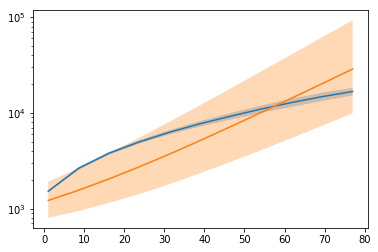

In [293]:
plt.figure()

plt.fill_between(tspace, y.mean(axis=0) - y.std(axis=0), y.mean(axis=0) + y.std(axis=0), alpha=0.3)
plt.plot(tspace, y.mean(axis=0))

plt.fill_between(tspace, expected_projection[:,1], expected_projection[:, 2], alpha=0.3)
plt.plot(tspace, expected_projection[:,0])

plt.yscale('log')

---

Save the network in `json` format.

In [310]:
import json
from networkx.readwrite import json_graph

with open('../data/ebola/ebola_scaled_graph.json', 'w') as f:
    graph_data = json_graph.node_link_data(graph)
    graph_data['graph']['partition'] = list(map(list, graph_data['graph']['partition'])) # Fix json compatibility by casting set to list
    json.dump(graph_data, f)